# Offensive Strategies

The goal of this document is to follow up on the "offensive strategies" work
item. We will look for interesting patterns in the dataset with particular
attention to offensive play characteristics.

Hypotheses to test:

- Offenses should use heavier running backs: Heavier running backs result in
  more missed tackles, as they're harder for would-be tacklers to bring down.
- Offenses should throw longer passes (if the goal is to avoid tackles):
  Receivers who catch longer passes are at lower risk of being tackled than
  receivers who catch shorter passes.
- Running certain offensive formations can result in more missed tackles,
  particularly for rushing plays.

Authors:

- Sean Shi (CSCI 4502)
- Tim Tripp (CSCI 5502)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.stats import chi2_contingency, probplot

## Prepare the dataset

In [2]:
df = pd.read_csv('../data/tackles.csv')
# In the NFL, normally one defender is credited with a tackle, but often there
# are multiple people involved with the tackle. Here they've been given the
# "assist" role.
tackles = df[(df['tackle'] == 1) | (df['assist'] == 1)]
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [3]:
plays = pd.read_csv('../data/plays.csv').set_index(['gameId', 'playId'])
# Joining with plays allows us to get information such as the offensive
# formation, whether a pass was successful, etc.
tackle_plays = tackles.join(
    other = plays,
    on = ['gameId', 'playId'],
    how = 'inner'
)
tackle_plays.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,ballCarrierId,ballCarrierDisplayName,playDescription,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022090800,101,42816,1,0,0,0,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,...,0.399819,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN
1,2022090800,393,46232,1,0,0,0,47853,Darrell Henderson,(7:45) (Shotgun) D.Henderson right guard to LA...,...,0.314065,0.685935,-0.015263,0.015263,2.458136,-0.386335,NaN,NaN,NaN,NaN
2,2022090800,486,40166,1,0,0,0,44881,Cooper Kupp,"(5:53) (No Huddle, Shotgun) M.Stafford pass sh...",...,0.272012,0.727988,-0.016078,0.016078,0.825719,-1.041838,NaN,NaN,NaN,NaN
3,2022090800,646,47939,1,0,0,0,47879,Dawson Knox,(1:53) J.Allen pass short left to D.Knox to LA...,...,0.204260,0.795740,-0.029484,0.029484,2.706385,1.352469,Horse Collar Tackle,NaN,47939.0,NaN
4,2022090800,818,40107,1,0,0,0,47853,Darrell Henderson,(15:00) (Shotgun) M.Stafford pass short left t...,...,0.250420,0.749580,-0.017527,0.017527,0.215741,-1.372731,NaN,NaN,NaN,NaN


In [4]:
players = pd.read_csv('../data/players.csv').set_index(['nflId'])
# Joining with players allows us to get information such as the ball carrier's
# height and weight.
tackle_plays = tackle_plays.join(
    other = players,
    on = ['ballCarrierId'],
    how = 'inner'
)
tackle_plays.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,ballCarrierId,ballCarrierDisplayName,playDescription,...,foulName1,foulName2,foulNFLId1,foulNFLId2,height,weight,birthDate,collegeName,position,displayName
0,2022090800,101,42816,1,0,0,0,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,...,NaN,NaN,NaN,NaN,5-7,203,1997-09-03,Florida Atlantic,RB,Devin Singletary
1,2022090800,393,46232,1,0,0,0,47853,Darrell Henderson,(7:45) (Shotgun) D.Henderson right guard to LA...,...,NaN,NaN,NaN,NaN,5-8,200,1997-08-19,Memphis,RB,Darrell Henderson
2,2022090800,486,40166,1,0,0,0,44881,Cooper Kupp,"(5:53) (No Huddle, Shotgun) M.Stafford pass sh...",...,NaN,NaN,NaN,NaN,6-2,208,1993-06-15,Eastern Washington,WR,Cooper Kupp
3,2022090800,646,47939,1,0,0,0,47879,Dawson Knox,(1:53) J.Allen pass short left to D.Knox to LA...,...,Horse Collar Tackle,NaN,47939.0,NaN,6-4,254,1996-11-14,Mississippi,TE,Dawson Knox
4,2022090800,818,40107,1,0,0,0,47853,Darrell Henderson,(15:00) (Shotgun) M.Stafford pass short left t...,...,NaN,NaN,NaN,NaN,5-8,200,1997-08-19,Memphis,RB,Darrell Henderson


## Hypothesis 1

Offenses should use heavier running backs: Heavier running backs result in more missed tackles, as they're harder for would-be tacklers to bring down.

In [5]:
df_runningbacks = players[players.position == 'RB']
df_runningbacks.head()

,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
37101,5-9,215,1989-12-21,Alabama,RB,Mark Ingram
39212,5-11,220,1990-01-26,Mississippi,RB,Brandon Bolden
39975,6-2,238,1991-03-17,Tennessee,RB,Cordarrelle Patterson
40129,6-3,230,1990-01-18,Central Florida,RB,Latavius Murray
40138,5-10,215,1990-07-02,Nebraska,RB,Rex Burkhead


For a comparison, let's see what the weight distribution is for some other offensive positions.

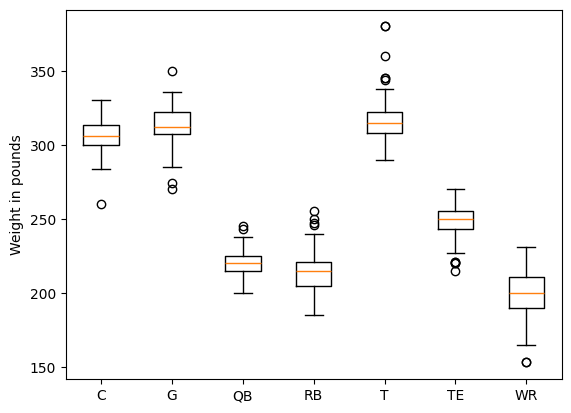

In [6]:
weights_grouped = players.groupby("position")["weight"]
positions = {"RB","TE","WR","G","T","C","QB"}
labels = [label for label, _ in weights_grouped if label in positions]
x = [x for label,x in weights_grouped if label in positions]
plt.boxplot(x, tick_labels = labels)
plt.ylabel('Weight in pounds')
plt.show()

From this we can draw the conclusion that NFL offenses place emphasis on heavier player weight for the key blocker positions of center (C), offensive guard (G), and offensive tackle (T), more so than for the running back (RB). Players playing quarterback (QB), wide reciever (WR), and tight end (TE) don't need to be as heavy to do their jobs effectively. Wide recievers come in at the lightest weight, which makes sense for a player needing to be agile enough to make mid-air catches.

In [7]:
grouped_tackles = tackles[['gameId', 'playId', 'tackle', 'assist', 'pff_missedTackle']].groupby(['gameId', 'playId']).sum()
grouped_tackles['play_tackle_or_assist'] = grouped_tackles.apply(lambda x: 1 if x.tackle > 0 or x.assist > 0 else 0, axis=1)
grouped_tackles['play_missed_tackle'] = grouped_tackles.apply(lambda x: 1 if x.pff_missedTackle > 0 else 0, axis=1)
grouped_tackles['play_tackle_or_assist_not_missed'] = grouped_tackles.apply(lambda x: 1 if x.play_tackle_or_assist == 1 and x.play_missed_tackle == 0 else 0, axis=1)
grouped_tackles.head()

tackle  assist  pff_missedTackle  play_tackle_or_assist  \
gameId     playId                                                            
2022090800 56           1       0                 0                      1   
           80           1       0                 0                      1   
           101          1       0                 0                      1   
           122          1       0                 0                      1   
           146          0       2                 0                      1   

                   play_missed_tackle  play_tackle_or_assist_not_missed  
gameId     playId                                                        
2022090800 56                       0                                 1  
           80                       0                                 1  
           101                      0                                 1  
           122                      0                                 1  
           146                      0                                 1

In [8]:
all_plays = plays.join(
    other = grouped_tackles,
    how = 'left'
)
all_runningback_plays = all_plays[['ballCarrierId', 'tackle', 'assist', 'pff_missedTackle', 'play_tackle_or_assist', 'play_missed_tackle', 'play_tackle_or_assist_not_missed', 'playResult']]
all_runningback_plays.head()

,,ballCarrierId,tackle,assist,pff_missedTackle,play_tackle_or_assist,play_missed_tackle,play_tackle_or_assist_not_missed,playResult
gameId,playId,,,,,,,,
2022100908,3537,48723,1.0,0.0,0.0,1.0,0.0,1.0,9
2022091103,3126,52457,1.0,0.0,0.0,1.0,0.0,1.0,3
2022091111,1148,42547,1.0,0.0,0.0,1.0,0.0,1.0,15
2022100212,2007,46461,0.0,2.0,0.0,1.0,0.0,1.0,7
2022091900,1372,47857,0.0,2.0,0.0,1.0,0.0,1.0,3


In [9]:
all_runningback_plays['play_count'] = 1
weight_runningback_plays = all_runningback_plays.groupby(['ballCarrierId']).sum()
weight_runningback_plays = weight_runningback_plays.join(
    other = players,
    on = ['ballCarrierId'],
    how = 'inner'
)
weight_runningback_plays = weight_runningback_plays[weight_runningback_plays.position == 'RB']
weight_runningback_plays['yards_per_play'] = weight_runningback_plays.playResult.div(weight_runningback_plays.play_count)
weight_runningback_plays['tackle_or_assist_play_percentage'] = weight_runningback_plays.play_tackle_or_assist.div(weight_runningback_plays.play_count).mul(100)
weight_runningback_plays['missed_tackle_play_percentage'] = weight_runningback_plays.play_missed_tackle.div(weight_runningback_plays.play_count).mul(100)

weight_runningback_plays

/var/folders/kj/hfcgqjtx6kl6t9k_b4fwwbwm0000gn/T/ipykernel_17622/3394321974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runningback_plays['play_count'] = 1


,tackle,assist,pff_missedTackle,play_tackle_or_assist,play_missed_tackle,play_tackle_or_assist_not_missed,playResult,play_count,height,weight,birthDate,collegeName,position,displayName,yards_per_play,tackle_or_assist_play_percentage,missed_tackle_play_percentage
ballCarrierId,,,,,,,,,,,,,,,,,
37101,37.0,55.0,0.0,61.0,0.0,61.0,211,62,5-9,215,1989-12-21,Alabama,RB,Mark Ingram,3.403226,98.387097,0.000000
39212,8.0,12.0,1.0,13.0,1.0,12.0,81,14,5-11,220,1990-01-26,Mississippi,RB,Brandon Bolden,5.785714,92.857143,7.142857
39975,60.0,42.0,0.0,75.0,0.0,75.0,396,81,6-2,238,1991-03-17,Tennessee,RB,Cordarrelle Patterson,4.888889,92.592593,0.000000
40129,43.0,29.0,2.0,52.0,2.0,50.0,196,55,6-3,230,1990-01-18,Central Florida,RB,Latavius Murray,3.563636,94.545455,3.636364
40138,40.0,16.0,0.0,47.0,0.0,47.0,198,48,5-10,215,1990-07-02,Nebraska,RB,Rex Burkhead,4.125000,97.916667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54905,33.0,23.0,0.0,41.0,0.0,41.0,224,41,5-8,225,NaN,Oklahoma State,RB,Jaylen Warren,5.463415,100.000000,0.000000
55014,9.0,5.0,0.0,11.0,0.0,11.0,41,12,5-9,194,NaN,Virginia Tech,RB,Raheem Blackshear,3.416667,91.666667,0.000000
55113,0.0,2.0,0.0,1.0,0.0,1.0,7,1,6-1,218,NaN,Georgia Tech,RB,Jordan Mason,7.000000,100.000000,0.000000


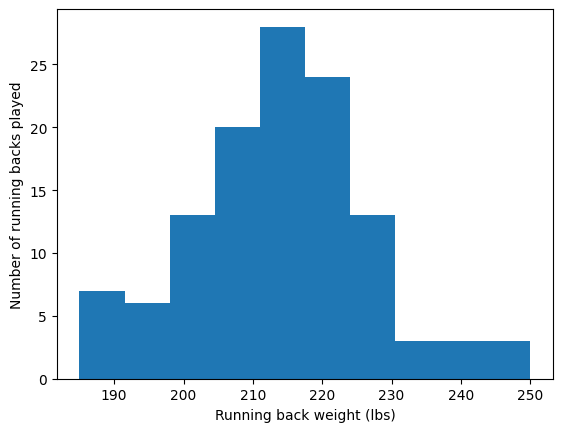

In [10]:
plt.hist(weight_runningback_plays.weight)
plt.xlabel('Running back weight (lbs)')
plt.ylabel('Number of running backs played')
plt.show()

This looks like a roughly a normal distribution, with an average weight somewhere between 210 and 220 pounds for played running backs.

This is supported by https://hortonbarbell.com/average-height-and-weight-of-nfl-running-backs/ which says:

> The average weight of an NFL Running Back is 213.17 pounds.

Note that this analysis only includes running backs that were actually played, and not those that were benched for every game.

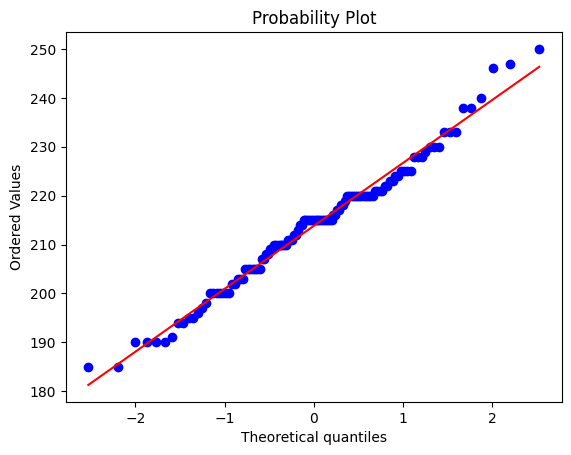

In [12]:
probplot(weight_runningback_plays.weight, dist="norm", plot=pylab)
pylab.show()

In [14]:
print('Mean:', np.mean(weight_runningback_plays.weight))
print('Standard deviation:', np.std(weight_runningback_plays.weight))

Mean: 213.81666666666666
Standard deviation: 12.746884150864302


(array([ 6.,  6., 11., 14., 17., 36., 14.,  7.,  5.,  1.,  3.]),
 array([185.        , 190.90909091, 196.81818182, 202.72727273,
        208.63636364, 214.54545455, 220.45454545, 226.36363636,
        232.27272727, 238.18181818, 244.09090909, 250.        ]),
 <BarContainer object of 11 artists>)

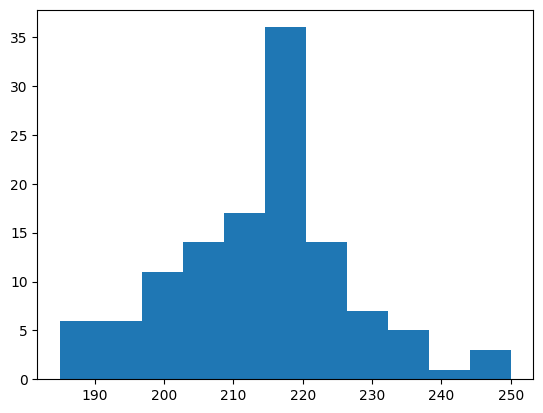

In [15]:
# Finds the optimal bins.
# https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
bins = plt.hist(weight_runningback_plays.weight, bins='auto')
bins

In [16]:
weight_runningback_plays['weight_category'] = pd.cut(weight_runningback_plays.weight, bins[1])
weight_runningback_tackle_plays_binned = weight_runningback_plays[['play_missed_tackle', 'play_tackle_or_assist_not_missed', 'weight_category']].groupby(['weight_category']).sum()
weight_runningback_tackle_plays_binned

/var/folders/kj/hfcgqjtx6kl6t9k_b4fwwbwm0000gn/T/ipykernel_17622/2934863629.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_runningback_tackle_plays_binned = weight_runningback_plays[['play_missed_tackle', 'play_tackle_or_assist_not_missed', 'weight_category']].groupby(['weight_category']).sum()


,play_missed_tackle,play_tackle_or_assist_not_missed
weight_category,,
"(185.0, 190.909]",2.0,97.0
"(190.909, 196.818]",1.0,212.0
"(196.818, 202.727]",2.0,718.0
"(202.727, 208.636]",4.0,550.0
"(208.636, 214.545]",4.0,1225.0
"(214.545, 220.455]",11.0,1740.0
"(220.455, 226.364]",10.0,623.0
"(226.364, 232.273]",7.0,576.0
"(232.273, 238.182]",3.0,409.0


In [17]:
chi2_contingency(weight_runningback_tackle_plays_binned)

Chi2ContingencyResult(statistic=np.float64(17.313475126034714), pvalue=np.float64(0.06770902792238324), dof=10, expected_freq=array([[6.80310726e-01, 9.83196893e+01],
       [1.46369883e+00, 2.11536301e+02],
       [4.94771437e+00, 7.15052286e+02],
       [3.80699134e+00, 5.50193009e+02],
       [8.44547356e+00, 1.22055453e+03],
       [1.20325665e+01, 1.73896743e+03],
       [4.34986555e+00, 6.28650134e+02],
       [4.00627428e+00, 5.78993726e+02],
       [2.83119211e+00, 4.09168808e+02],
       [2.88616672e-01, 4.17113833e+01],
       [3.14729609e+00, 4.54852704e+02]]))

This p-value is insufficent to disprove the null hypothesis that a running back's weight does not affect his number of plays with at least one missed tackle.

In [18]:
weight_runningback_yard_plays_binned = weight_runningback_plays[['playResult', 'play_count', 'weight_category']].groupby(['weight_category']).sum()
weight_runningback_yard_plays_binned['yards_per_play'] = weight_runningback_yard_plays_binned.playResult.div(weight_runningback_yard_plays_binned.play_count)
weight_runningback_yard_plays_binned

/var/folders/kj/hfcgqjtx6kl6t9k_b4fwwbwm0000gn/T/ipykernel_17622/23904394.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_runningback_yard_plays_binned = weight_runningback_plays[['playResult', 'play_count', 'weight_category']].groupby(['weight_category']).sum()


,playResult,play_count,yards_per_play
weight_category,,,
"(185.0, 190.909]",513,100,5.130000
"(190.909, 196.818]",1109,220,5.040909
"(196.818, 202.727]",3684,749,4.918558
"(202.727, 208.636]",3050,564,5.407801
"(208.636, 214.545]",6071,1285,4.724514
"(214.545, 220.455]",8335,1801,4.627984
"(220.455, 226.364]",2947,649,4.540832
"(226.364, 232.273]",2274,597,3.809045
"(232.273, 238.182]",2076,429,4.839161


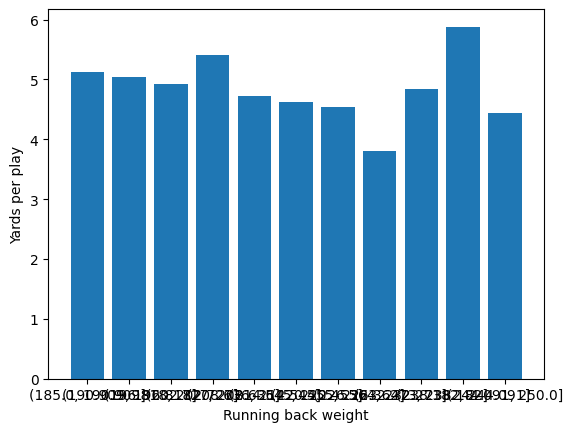

In [19]:
plt.bar(weight_runningback_yard_plays_binned.index.astype(str), weight_runningback_yard_plays_binned.yards_per_play.values)
plt.xlabel('Running back weight')
plt.ylabel('Yards per play')
plt.show()

In conclusion, the weight of a running back doesn't have a statistically significant affect on his ability to cause missed tackles. The evidence is insufficent to support the first offensive strategy hypothesis. However, there does seem to be a target weight for played NFL running backs, as it follows a roughly normal distribution with a mean of 213.82 pounds and standard deviation of 12.75 pounds.